In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from icedef import statoil_arcticnet_data as sd
from icedef import test_case, plot, simulator

In [2]:
plt.rcParams['figure.figsize'] = (12, 12)

In [3]:
def calc_mean_error(lats_lons, ref_lats_lons):
    
    # lats_lons and ref_lats_lons must be a list of xarray DataArrays with time as a dimension
    
    lats, lons = lats_lons
    ref_lats, ref_lons = ref_lats_lons
    
    n = len(ref_lats.values)
    
    errs = np.zeros(n)
    
    for i in range(n):
        ref_lat = ref_lats.values[i]
        ref_lon = ref_lons.values[i]
        time = ref_lats.time.values[i]
        lat = float(lats.interp(time=time, assume_sorted=True).values)
        lon = float(lons.interp(time=time, assume_sorted=True).values)
        errs[i] = np.sqrt((ref_lon - lon)**2 + (ref_lat - lat)**2)
    
    return np.mean(errs)

# Test Case B (Beacons 204980 and 906790)

In [4]:
beacon_id = '20498'
df = sd.get_beacon_df(beacon_id=beacon_id)

# Day 1

In [5]:
# note index 809 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[809]
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

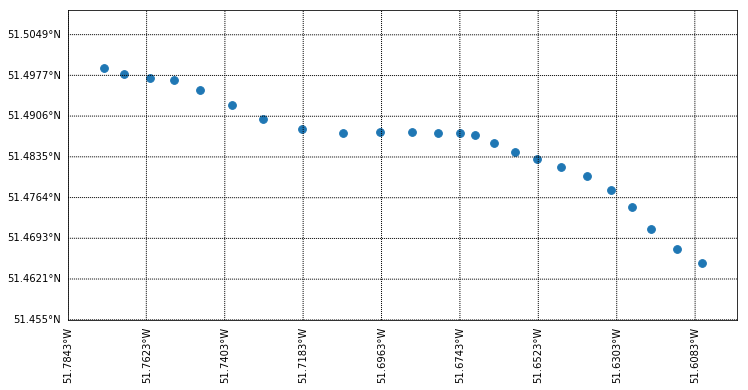

In [6]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

## Find optimal Ca and Cw

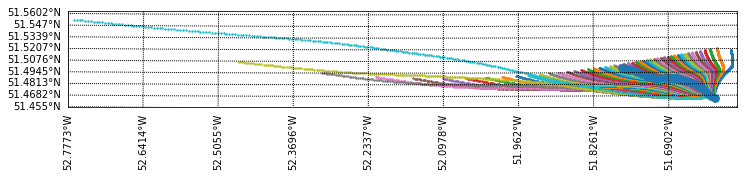

In [7]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.00786211268939867, Ca: 1.4000000000000001, Cw: 1.0999999999999999


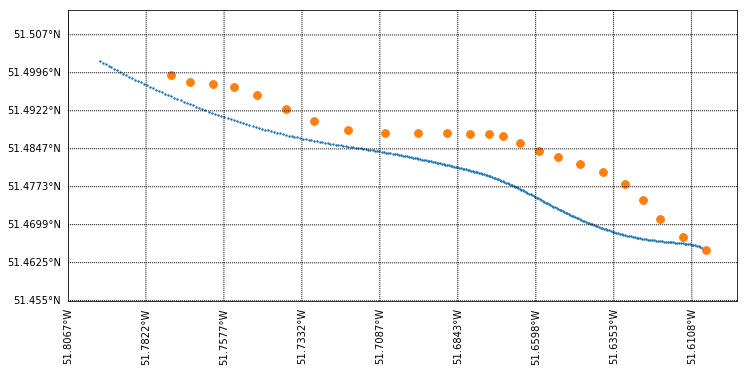

In [8]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

## Running Ensemble

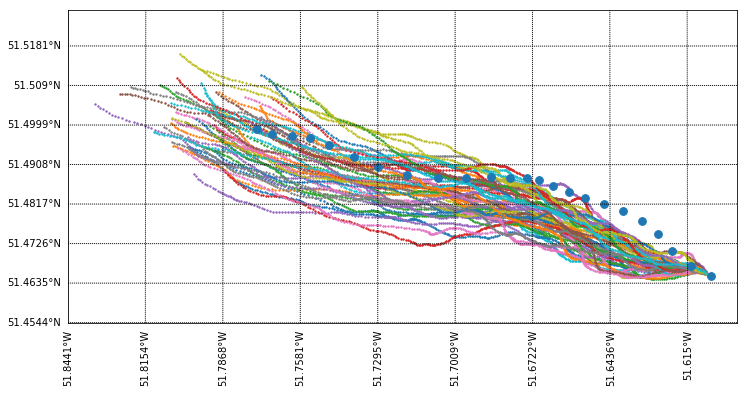

In [58]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 1.4, 1.1
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}

N = 50

num_start_times = 1

for j in range(num_start_times):

    for i in range(N):

        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)


labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

## Plotting metocean data

In [9]:
def do_stuff(field, velocity_field, lon_bounds, lat_bounds, time_bounds):
    
    xs = field.data.longitude.values
    ys = field.data.latitude.values
    ts = field.data.time.values
    uos = velocity_field.eastward_velocities
    vos = velocity_field.northward_velocities

    xi = lon_bounds[0]
    xf = lon_bounds[1]
    yi = lat_bounds[0]
    yf = lat_bounds[1]
    ti = time_bounds[0]
    tf = time_bounds[1]
    xi_index = np.argmin(abs(xs - xi))
    xf_index = np.argmin(abs(xs - xf))
    yi_index = np.argmin(abs(ys - yi))
    yf_index = np.argmin(abs(ys - yf))
    ti_index = np.argmin(abs(ts - ti))
    tf_index = np.argmin(abs(ts - tf))

    xs = field.data.longitude.values[xi_index : xf_index + 1]
    ys = field.data.latitude.values[yi_index : yf_index + 1]
    ts = field.data.time.values[ti_index : tf_index + 1]
    uos = velocity_field.eastward_velocities.values[ti_index : tf_index + 1, yi_index : yf_index + 1, xi_index : xf_index + 1]
    vos = velocity_field.northward_velocities[ti_index : tf_index + 1, yi_index : yf_index + 1, xi_index : xf_index + 1]
    uos = np.mean(uos, axis=0)
    vos = np.mean(vos, axis=0)
    
    map_kwargs = plot.get_map_kwargs(ys[0], xs[0], ys[-1], xs[-1])
    map_ = plot.get_map(**map_kwargs)
    
    parallels = map_.drawparallels(np.arange(ys[0], ys[-1] + np.mean(np.diff(ys)), np.mean(np.diff(ys))),labels=[1,0,0,1])
    meridians = map_.drawmeridians(np.arange(xs[0], xs[-1] + np.mean(np.diff(xs)), np.mean(np.diff(xs))),labels=[1,0,0,1])
    for meridian in meridians:

        try:
            meridians[meridian][1][0].set_rotation(90)

        except IndexError:
            pass
    
    xs_, ys_ = map_(xs, ys)
    xs_1 = np.append(xs_, xs_[-1] + np.mean(np.diff(xs_))) - np.mean(np.diff(xs_)) / 2
    ys_1 = np.append(ys_, ys_[-1] + np.mean(np.diff(ys_))) - np.mean(np.diff(ys_)) / 2
    xxs, yys = np.meshgrid(xs_1, ys_1)
    #map_.imshow(np.sqrt(uos**2 + vos**2), origin='lower', interpolation='bicubic')
    map_.pcolor(xxs, yys, np.sqrt(uos**2 + vos**2))
    map_.quiver(xs_, ys_, uos, vos, units='xy', angles='xy')
    plt.colorbar()
    berg_xs = tc.ref_lons.values
    berg_ys = tc.ref_lats.values
    berg_xs_, berg_ys_ = map_(berg_xs, berg_ys)
    map_.scatter(berg_xs_, berg_ys_, color='r') 

In [12]:
lon_bounds = (-52, -51.5) #(-52.5, -50.5)
lat_bounds = (51.2, 51.7) #(50.5, 52.5)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

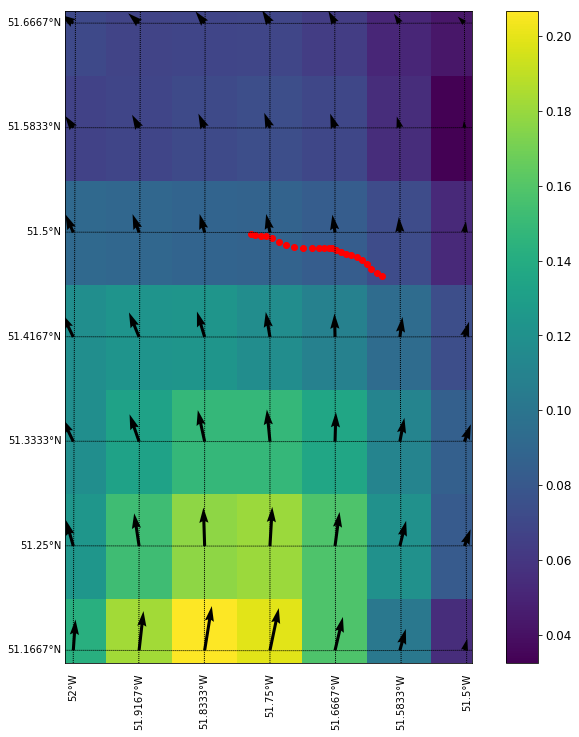

In [13]:
do_stuff(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds)

In [14]:
lon_bounds = (-52.5, -50.5)
lat_bounds = (50.5, 52.5)

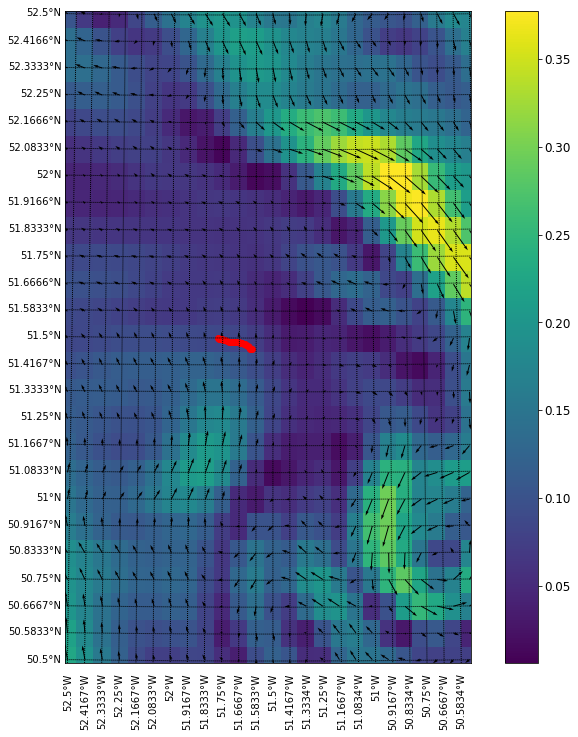

In [15]:
do_stuff(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds)

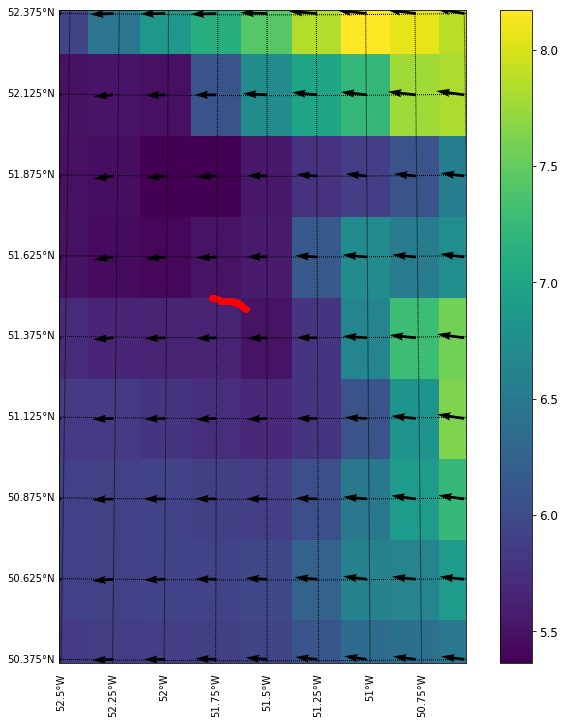

In [16]:
do_stuff(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds)

# Test Case C (Beacons 505190 and 907780)

In [4]:
beacon_id = '50519'
df = sd.get_beacon_df(beacon_id=beacon_id)

# Day 1

In [5]:
# note index 537 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[537]
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

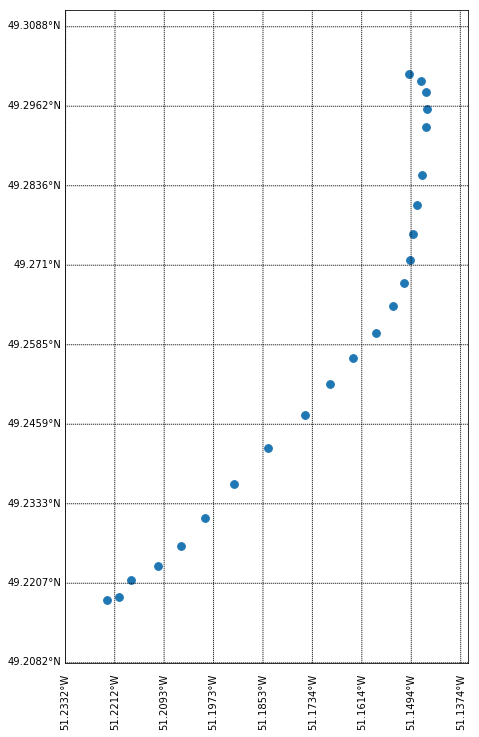

In [6]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

## Find optimal Ca and Cw

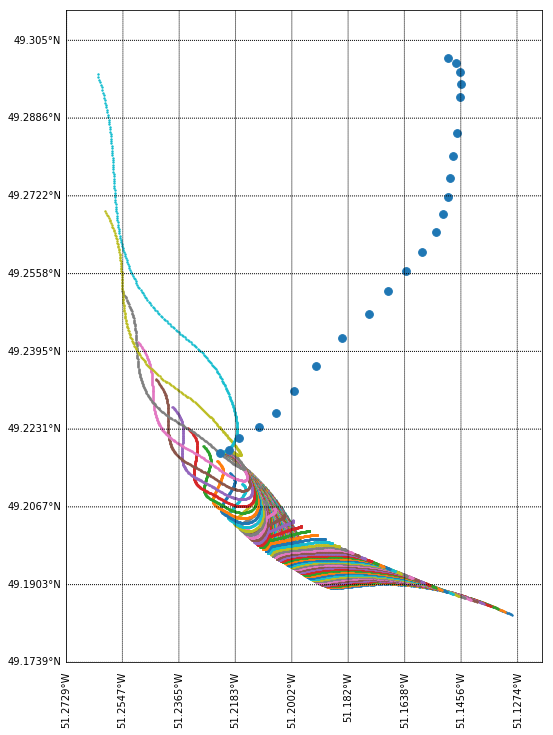

In [7]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
# run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
#                   'perturb_current': True, 'perturb_wind': True,
#                   'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0, 0]), 'wind_constants': np.array([0, 0])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.06496654087149482, Ca: 2.45, Cw: 0.04999999999999982


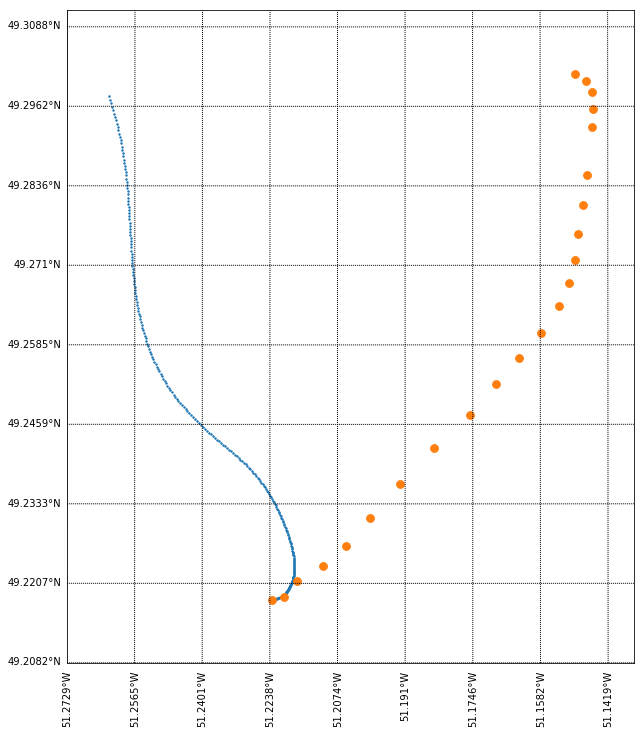

In [9]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

## Plotting metocean data

In [25]:
def do_stuff(field, velocity_field, lon_bounds, lat_bounds, time_bounds):
    
    xs = field.data.longitude.values
    ys = field.data.latitude.values
    ts = field.data.time.values
    uos = velocity_field.eastward_velocities
    vos = velocity_field.northward_velocities

    xi = lon_bounds[0]
    xf = lon_bounds[1]
    yi = lat_bounds[0]
    yf = lat_bounds[1]
    ti = time_bounds[0]
    tf = time_bounds[1]
    xi_index = np.argmin(abs(xs - xi))
    xf_index = np.argmin(abs(xs - xf))
    yi_index = np.argmin(abs(ys - yi))
    yf_index = np.argmin(abs(ys - yf))
    ti_index = np.argmin(abs(ts - ti))
    tf_index = np.argmin(abs(ts - tf))

    xs = field.data.longitude.values[xi_index : xf_index + 1]
    ys = field.data.latitude.values[yi_index : yf_index + 1]
    ts = field.data.time.values[ti_index : tf_index + 1]
    uos = velocity_field.eastward_velocities.values[ti_index : tf_index + 1, yi_index : yf_index + 1, xi_index : xf_index + 1]
    vos = velocity_field.northward_velocities[ti_index : tf_index + 1, yi_index : yf_index + 1, xi_index : xf_index + 1]
    uos = np.mean(uos, axis=0)
    vos = np.mean(vos, axis=0)
    
    map_kwargs = plot.get_map_kwargs(ys[0], xs[0], ys[-1], xs[-1])
    map_ = plot.get_map(**map_kwargs)
    
    parallels = map_.drawparallels(np.arange(ys[0], ys[-1] + np.mean(np.diff(ys)), np.mean(np.diff(ys))),labels=[1,0,0,1])
    meridians = map_.drawmeridians(np.arange(xs[0], xs[-1] + np.mean(np.diff(xs)), np.mean(np.diff(xs))),labels=[1,0,0,1])
    for meridian in meridians:

        try:
            meridians[meridian][1][0].set_rotation(90)

        except IndexError:
            pass
    
    xs_, ys_ = map_(xs, ys)
    xs_1 = np.append(xs_, xs_[-1] + np.mean(np.diff(xs_))) - np.mean(np.diff(xs_)) / 2
    ys_1 = np.append(ys_, ys_[-1] + np.mean(np.diff(ys_))) - np.mean(np.diff(ys_)) / 2
    xxs, yys = np.meshgrid(xs_1, ys_1)
    #map_.imshow(np.sqrt(uos**2 + vos**2), origin='lower', interpolation='bicubic')
    map_.pcolor(xxs, yys, np.sqrt(uos**2 + vos**2))
    map_.quiver(xs_, ys_, uos, vos, units='xy', angles='xy')
    plt.colorbar()
    berg_xs = tc.ref_lons.values
    berg_ys = tc.ref_lats.values
    berg_xs_, berg_ys_ = map_(berg_xs, berg_ys)
    map_.scatter(berg_xs_, berg_ys_, color='r') 

In [26]:
lon_bounds = (-51.5, -51)
lat_bounds = (49, 49.5)
time_bounds = [tc.ref_times[0], tc.ref_times[0] + np.timedelta64(1, 'h')]

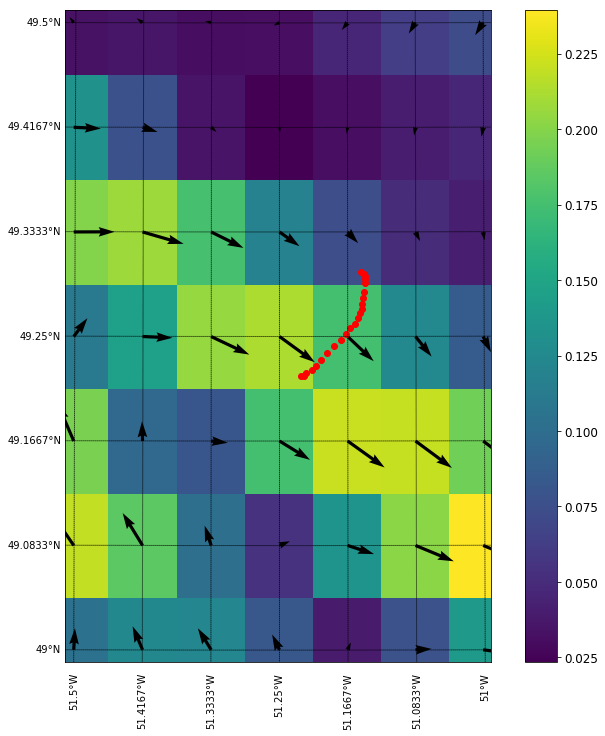

In [27]:
do_stuff(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds)

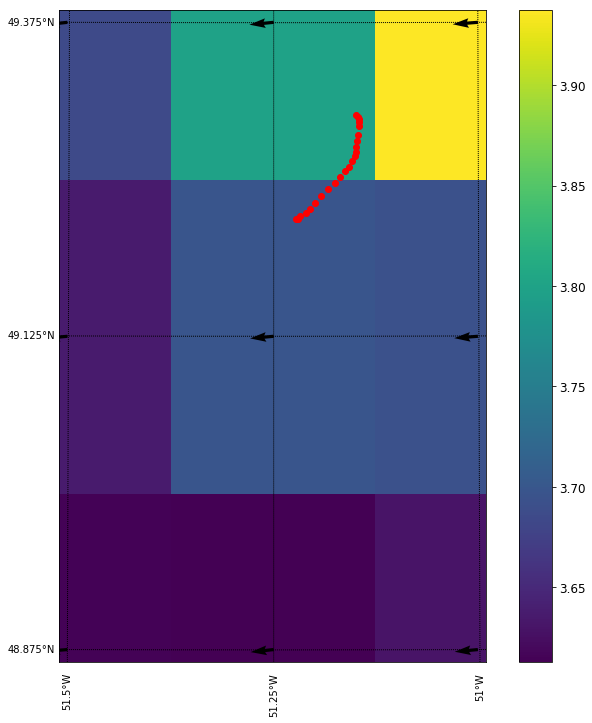

In [28]:
do_stuff(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds)

In [83]:
reload(simulator)
reload(metocean)

<module 'icedef.metocean' from '/home/evankielley/IceDEF/icedef/metocean.py'>

In [84]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

In [20]:
point = (tc.ref_times[0], tc.ref_lats.values[0], tc.ref_lons.values[0])
sim.ocean.current.interpolate(point)

array([ 0.15801694, -0.11569915])

In [11]:
sim.ocean.current.eastward_velocities.interp(time=point[0], latitude=point[1], longitude=point[2], assume_sorted=True)

<xarray.DataArray ()>
array(0.158017)
Coordinates:
    time       datetime64[ns] 2015-04-23T23:59:26
    latitude   float64 49.22
    longitude  float64 -51.22
Attributes:
    standard_name:    eastward_sea_water_velocity
    long_name:        Eastward velocity
    units:            m s-1
    _CoordinateAxes:  time depth latitude longitude 
    unit_long:        Meters per second
    cell_methods:     area: mean

In [12]:
sim.ocean.current.northward_velocities.interp(time=point[0], latitude=point[1], longitude=point[2], assume_sorted=True)

<xarray.DataArray ()>
array(-0.115699)
Coordinates:
    time       datetime64[ns] 2015-04-23T23:59:26
    latitude   float64 49.22
    longitude  float64 -51.22
Attributes:
    standard_name:    eastward_sea_water_velocity
    long_name:        Eastward velocity
    units:            m s-1
    _CoordinateAxes:  time depth latitude longitude 
    unit_long:        Meters per second
    cell_methods:     area: mean

In [13]:
sim.atmosphere.wind.interpolate(point)

array([-3.72012128, -0.33757185])

In [22]:
xos = sim.ocean.data.longitude.values
yos = sim.ocean.data.latitude.values
tos = sim.ocean.data.time.values
uos = sim.ocean.current.eastward_velocities.values

xi = point[2]
yi = point[1]
ti = point[0]

xi_index = np.argmin(abs(xos - xi))
yi_index = np.argmin(abs(yos - yi))
ti_index = np.argmin(abs(tos - ti))

In [23]:
xi_index

165

In [24]:
uos[ti_index : ti_index + 1, yi_index : yi_index + 1, xi_index : xi_index + 1]

array([[[0.17883846]]], dtype=float32)